In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from sklearn.metrics import roc_curve, auc
import numpy as np
import math
import gzip
import os
import time
from scipy import stats
import math
import gc

In [3]:
z_scores = {95: 1.96, 90: 1.645}

In [4]:
def calc_ci(array, z=1.96): # Z = 1.96 for 95% CI
    x_bar = np.mean(array)
    s = np.std(array)
    n = len(array)
    lower = x_bar - (z * (s/math.sqrt(n)))
    upper = x_bar + (z * (s/math.sqrt(n)))
    med = np.median(array)
    return lower, med, upper

In [5]:
def plot_thresholds(merge, title, stars=0, plot_auc=False):
    
    copy_merge = merge.copy(deep=True)
    
    if 'stars' in merge.columns:
        copy_merge = copy_merge[copy_merge['stars'] >= stars]
    
    before_drop = copy_merge.shape[0]
    copy_merge.drop(index=copy_merge[(copy_merge['ref'].str.len() > 50) | (copy_merge['alt'].str.len() > 50)].index, inplace=True)
    copy_merge.reset_index(drop=True, inplace=True)
    print(f'A total of: {before_drop - copy_merge.shape[0]} CNVs have been filtered out.')
    
    benign_subset = copy_merge[copy_merge['binarized_label'] == 0]
    benign_scores = benign_subset['probabilities']
    percentile_benign = np.percentile(benign_scores, 95)
    benign_lower_ci, benign_med, benign_upper_ci = calc_ci(benign_scores[benign_scores <= percentile_benign])
    alt_benign_lower_ci, alt_benign_med, alt_benign_upper_ci = calc_ci(benign_scores)
    
    pathogenic_subset = copy_merge[copy_merge['binarized_label'] == 1]
    patho_scores = pathogenic_subset['probabilities']
    percentile_patho = np.percentile(patho_scores, 5)
    patho_lower_ci, patho_med, patho_upper_ci = calc_ci(patho_scores[patho_scores >= percentile_patho])
    alt_patho_lower_ci, alt_patho_med, alt_patho_upper_ci = calc_ci(patho_scores)
    
    dot_size = 0.3
    n_decimals = 4
    
    fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(20,20))

    for n, threshold in enumerate(((percentile_benign, percentile_patho), (benign_upper_ci, patho_lower_ci), (alt_benign_upper_ci, alt_patho_lower_ci))):
        
        benign_threshold = threshold[0]

        axes[n].axhspan(0,
                    benign_threshold,
                    0,
                    1,
                    color='green',
                    alpha=0.4
                   )

        n_benign_correct = benign_subset[benign_subset['probabilities'] <= benign_threshold].shape[0]
        n_benign_tot = benign_subset.shape[0]
    
        axes[n].scatter(benign_subset['sample'],
                    benign_subset['probabilities'],
                    s=dot_size,
                    color='green',
                    label=f'benign (n={benign_subset.shape[0]}) \n {n_benign_correct}/{n_benign_tot} ({round(n_benign_correct/n_benign_tot*100)}%)'
                   )

        pathogenic_threshold = threshold[1]

        axes[n].axhspan(pathogenic_threshold,
                    1,
                    0,
                    1,
                    color='red',
                    alpha=0.4
                   )

        n_patho_correct = pathogenic_subset[pathogenic_subset['probabilities'] >= pathogenic_threshold].shape[0]
        n_patho_tot = pathogenic_subset.shape[0]

        axes[n].scatter(pathogenic_subset['sample'],
                    pathogenic_subset['probabilities'],
                    s=dot_size,
                    color='red',
                    label=f'pathogenic (n={pathogenic_subset.shape[0]}) \n {n_patho_correct}/{n_patho_tot} ({round(n_patho_correct/n_patho_tot*100)}%)'
                   )

        handles, labels = axes[n].get_legend_handles_labels()

        red_patch = mpatches.Patch(color='red', label=f'P area ({round(pathogenic_threshold, n_decimals)}-1)')
        handles.append(red_patch)
        green_patch = mpatches.Patch(color='green', label=f'B area (0-{round(benign_threshold, n_decimals)})')
        handles.append(green_patch)
        axes[n].legend(bbox_to_anchor=(1.0,1.0), handles=handles, prop={'size':15})

        axes[n].set_ylabel('CAPICE score')
        axes[n].set_xlabel('Sample')
        if n == 0:
            axes[n].set_title(f'95 quantile: {title}')
        elif n == 1:
            axes[n].set_title(f'95% CI: {title}')
        elif n == 2:
            axes[n].set_title(f'95 quantile, 95% CI: {title}')
    
    plt.show()
    plt.clf()
    if plot_auc:
    
        fig, axes = plt.subplots(1,1,figsize=(20,8))
        
        fpr, tpr, _ = roc_curve(y_score=copy_merge['probabilities'], y_true=copy_merge['binarized_label'])
        auc_score = round(auc(fpr, tpr), 4)
    
        # Plotting random guessing
        axes.plot([0,1], [0,1], color='navy', linestyle='--')
        axes.plot(fpr, tpr, color='black', label=f'ROC (area={auc_score})')
        axes.set_xlim([0.0, 1.0])
        axes.set_ylim([0.0, 1.05])
        axes.set_xlabel('FPR')
        axes.set_ylabel('TPR')
        axes.set_title('Receiver Operating Curve')
        axes.legend()

        plt.show()
        plt.clf()
    
    

In [6]:
labels = pd.read_csv('/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Thresholds/test.txt.gz', sep='\t')
labels

/home/rjsietsma/PycharmProjects/capice_updatr/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (55,63,73,112) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#Chrom  Allergy/Immunology/Infectious Alt          AnnoType  \
0         21                          False   G  CodingTranscript   
1          X                          False   C  CodingTranscript   
2         17                          False   T  CodingTranscript   
3         21                          False   T  CodingTranscript   
4          1                          False   A  CodingTranscript   
...      ...                            ...  ..               ...   
10837     17                          False   A  CodingTranscript   
10838     11                           True   T  CodingTranscript   
10839     15                          False   C  CodingTranscript   
10840     19                           True   A  CodingTranscript   
10841     16                          False   C  CodingTranscript   

       Audiologic/Otolaryngologic  Biochemical         CCDS  CDSpos  \
0                           False        False  CCDS13617.1   872.0   
1                           False        False  CCDS55462.1  1971.0   
2                           False        False  CCDS42292.1   843.0   
3                           False        False  CCDS13635.1   222.0   
4                           False        False     CCDS39.1   768.0   
...                           ...          ...          ...     ...   
10837                       False        False  CCDS42292.1  2709.0   
10838                       False        False   CCDS7753.1    75.0   
10839                       False        False  CCDS32232.1  2673.0   
10840                       False        False  CCDS12366.1  1767.0   
10841                       False        False  CCDS10398.1   427.0   

       Cardiovascular  ConsDetail  ...  relProtPos relcDNApos  revel   sift  \
0               False   stop_lost  ...    1.003448   0.883570    NaN    NaN   
1               False  synonymous  ...    0.572300   0.373821    NaN  0.000   
2                True  synonymous  ...    0.098979   0.098672    NaN  0.647   
3                True  synonymous  ...    0.601626   0.344434    NaN  0.000   
4                True  synonymous  ...    0.351648   0.149653    NaN  0.000   
...               ...         ...  ...         ...        ...    ...    ...   
10837            True  synonymous  ...    0.318070   0.248853    NaN  0.000   
10838            True  synonymous  ...    0.170068   0.199045    NaN  0.000   
10839            True  synonymous  ...    0.310345   0.266162    NaN  0.664   
10840           False  synonymous  ...    0.524021   0.343704    NaN  0.000   
10841           False   stop_lost  ...    1.007042   0.814876    NaN    NaN   

        source  tOverlapMotifs  targetScan to_be_deleted verPhCons  verPhyloP  
0      unknown             NaN         NaN         False     1.000      1.521  
1      clinvar             NaN         NaN         False     0.004     -1.525  
2      clinvar             NaN         NaN         False     0.991     -0.055  
3      clinvar             NaN         NaN         False     1.000      1.309  
4      clinvar             NaN         NaN         False     0.997      0.104  
...        ...             ...         ...           ...       ...        ...  
10837  clinvar             NaN         NaN         False     1.000      1.989  
10838  clinvar             NaN         NaN         False     0.943      0.189  
10839  clinvar             NaN         NaN         False     0.999      4.269  
10840  clinvar             NaN         NaN         False     0.996     -0.044  
10841  clinvar             NaN         NaN         False     1.000      3.588  

[10842 rows x 151 columns]

In [7]:
labels['chr_pos_ref_alt'] = labels[['#Chrom', 'Pos', 'Ref', 'Alt']].astype(str).agg('_'.join, axis=1)
labels

#Chrom  Allergy/Immunology/Infectious Alt          AnnoType  \
0         21                          False   G  CodingTranscript   
1          X                          False   C  CodingTranscript   
2         17                          False   T  CodingTranscript   
3         21                          False   T  CodingTranscript   
4          1                          False   A  CodingTranscript   
...      ...                            ...  ..               ...   
10837     17                          False   A  CodingTranscript   
10838     11                           True   T  CodingTranscript   
10839     15                          False   C  CodingTranscript   
10840     19                           True   A  CodingTranscript   
10841     16                          False   C  CodingTranscript   

       Audiologic/Otolaryngologic  Biochemical         CCDS  CDSpos  \
0                           False        False  CCDS13617.1   872.0   
1                           False        False  CCDS55462.1  1971.0   
2                           False        False  CCDS42292.1   843.0   
3                           False        False  CCDS13635.1   222.0   
4                           False        False     CCDS39.1   768.0   
...                           ...          ...          ...     ...   
10837                       False        False  CCDS42292.1  2709.0   
10838                       False        False   CCDS7753.1    75.0   
10839                       False        False  CCDS32232.1  2673.0   
10840                       False        False  CCDS12366.1  1767.0   
10841                       False        False  CCDS10398.1   427.0   

       Cardiovascular  ConsDetail  ...  relProtPos relcDNApos  revel   sift  \
0               False   stop_lost  ...    1.003448   0.883570    NaN    NaN   
1               False  synonymous  ...    0.572300   0.373821    NaN  0.000   
2                True  synonymous  ...    0.098979   0.098672    NaN  0.647   
3                True  synonymous  ...    0.601626   0.344434    NaN  0.000   
4                True  synonymous  ...    0.351648   0.149653    NaN  0.000   
...               ...         ...  ...         ...        ...    ...    ...   
10837            True  synonymous  ...    0.318070   0.248853    NaN  0.000   
10838            True  synonymous  ...    0.170068   0.199045    NaN  0.000   
10839            True  synonymous  ...    0.310345   0.266162    NaN  0.664   
10840           False  synonymous  ...    0.524021   0.343704    NaN  0.000   
10841           False   stop_lost  ...    1.007042   0.814876    NaN    NaN   

        source  tOverlapMotifs  targetScan to_be_deleted verPhCons  verPhyloP  
0      unknown             NaN         NaN         False     1.000      1.521  
1      clinvar             NaN         NaN         False     0.004     -1.525  
2      clinvar             NaN         NaN         False     0.991     -0.055  
3      clinvar             NaN         NaN         False     1.000      1.309  
4      clinvar             NaN         NaN         False     0.997      0.104  
...        ...             ...         ...           ...       ...        ...  
10837  clinvar             NaN         NaN         False     1.000      1.989  
10838  clinvar             NaN         NaN         False     0.943      0.189  
10839  clinvar             NaN         NaN         False     0.999      4.269  
10840  clinvar             NaN         NaN         False     0.996     -0.044  
10841  clinvar             NaN         NaN         False     1.000      3.588  

[10842 rows x 151 columns]

In [8]:
data = pd.read_csv('/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Thresholds/test_capice.txt.gz', sep='\t')
data

chr_pos_ref_alt  GeneName        FeatureID Consequence  probabilities
0      21_33974174_C_G  C21orf59  ENST00000290155   STOP_LOST       0.003275
1       X_99661625_G_C    PCDH19  ENST00000373034  SYNONYMOUS       0.000075
2      17_29509638_C_T       NF1  ENST00000358273  SYNONYMOUS       0.001511
3      21_35742999_C_T     KCNE2  ENST00000290310  SYNONYMOUS       0.000621
4        1_2160973_G_A       SKI  ENST00000378536  SYNONYMOUS       0.000012
...                ...       ...              ...         ...            ...
10837  17_29556342_G_A       NF1  ENST00000358273  SYNONYMOUS       0.000139
10838   11_5248177_A_T       HBB  ENST00000335295  SYNONYMOUS       0.069934
10839  15_48787324_T_C      FBN1  ENST00000316623  SYNONYMOUS       0.909190
10840  19_17947957_G_A      JAK3  ENST00000458235  SYNONYMOUS       0.001238
10841    16_223597_T_C      HBA2  ENST00000251595   STOP_LOST       0.971616

[10842 rows x 5 columns]

In [9]:
merge = data.merge(labels[['chr_pos_ref_alt', 'binarized_label']])
merge

chr_pos_ref_alt  GeneName        FeatureID Consequence  probabilities  \
0      21_33974174_C_G  C21orf59  ENST00000290155   STOP_LOST       0.003275   
1       X_99661625_G_C    PCDH19  ENST00000373034  SYNONYMOUS       0.000075   
2      17_29509638_C_T       NF1  ENST00000358273  SYNONYMOUS       0.001511   
3      21_35742999_C_T     KCNE2  ENST00000290310  SYNONYMOUS       0.000621   
4        1_2160973_G_A       SKI  ENST00000378536  SYNONYMOUS       0.000012   
...                ...       ...              ...         ...            ...   
10837  17_29556342_G_A       NF1  ENST00000358273  SYNONYMOUS       0.000139   
10838   11_5248177_A_T       HBB  ENST00000335295  SYNONYMOUS       0.069934   
10839  15_48787324_T_C      FBN1  ENST00000316623  SYNONYMOUS       0.909190   
10840  19_17947957_G_A      JAK3  ENST00000458235  SYNONYMOUS       0.001238   
10841    16_223597_T_C      HBA2  ENST00000251595   STOP_LOST       0.971616   

       binarized_label  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
10837                1  
10838                1  
10839                1  
10840                1  
10841                1  

[10842 rows x 6 columns]

In [10]:
merge[['chr', 'pos', 'ref', 'alt']] = merge['chr_pos_ref_alt'].str.split('_', expand=True)
merge.drop(columns='chr_pos_ref_alt', inplace=True)
merge

GeneName        FeatureID Consequence  probabilities  binarized_label  \
0      C21orf59  ENST00000290155   STOP_LOST       0.003275                0   
1        PCDH19  ENST00000373034  SYNONYMOUS       0.000075                0   
2           NF1  ENST00000358273  SYNONYMOUS       0.001511                0   
3         KCNE2  ENST00000290310  SYNONYMOUS       0.000621                0   
4           SKI  ENST00000378536  SYNONYMOUS       0.000012                0   
...         ...              ...         ...            ...              ...   
10837       NF1  ENST00000358273  SYNONYMOUS       0.000139                1   
10838       HBB  ENST00000335295  SYNONYMOUS       0.069934                1   
10839      FBN1  ENST00000316623  SYNONYMOUS       0.909190                1   
10840      JAK3  ENST00000458235  SYNONYMOUS       0.001238                1   
10841      HBA2  ENST00000251595   STOP_LOST       0.971616                1   

      chr       pos ref alt  
0      21  33974174   C   G  
1       X  99661625   G   C  
2      17  29509638   C   T  
3      21  35742999   C   T  
4       1   2160973   G   A  
...    ..       ...  ..  ..  
10837  17  29556342   G   A  
10838  11   5248177   A   T  
10839  15  48787324   T   C  
10840  19  17947957   G   A  
10841  16    223597   T   C  

[10842 rows x 9 columns]

In [11]:
merge['order'] = merge['chr']
merge.loc[merge[merge['order'] == 'X'].index, 'order'] = 23
merge.loc[merge[merge['order'] == 'Y'].index, 'order'] = 24
merge.loc[merge[merge['order'] == 'MT'].index, 'order'] = 25
merge['order'] = merge['order'].astype(int)
merge.sort_values(by=['order', 'pos'], inplace=True)
merge.drop(columns='order', inplace=True)
merge.index = range(0, merge.shape[0])
merge

GeneName        FeatureID       Consequence  probabilities  \
0          AGL  ENST00000294724    NON_SYNONYMOUS       0.000446   
1          AGL  ENST00000294724       FRAME_SHIFT       0.973992   
2          AGL  ENST00000294724       STOP_GAINED       0.910350   
3          AGL  ENST00000294724       FRAME_SHIFT       0.684197   
4          AGL  ENST00000294724  CANONICAL_SPLICE       0.812289   
...        ...              ...               ...            ...   
10837   PCDH19  ENST00000373034        SYNONYMOUS       0.000075   
10838   PCDH19  ENST00000373034    NON_SYNONYMOUS       0.863940   
10839   PCDH19  ENST00000373034       STOP_GAINED       0.998694   
10840    SRPX2  ENST00000373004    NON_SYNONYMOUS       0.001957   
10841    SRPX2  ENST00000373004    NON_SYNONYMOUS       0.000320   

       binarized_label chr        pos ref alt  
0                    0   1  100340326   G   A  
1                    1   1  100342111  TG   T  
2                    1   1  100346885   G   A  
3                    1   1  100346952   G  GA  
4                    1   1  100349675   G   A  
...                ...  ..        ...  ..  ..  
10837                0   X   99661625   G   C  
10838                0   X   99662275   C   G  
10839                0   X   99663098   G  GT  
10840                0   X   99917338   G   A  
10841                0   X   99922373   G   A  

[10842 rows x 9 columns]

In [12]:
merge['sample'] = merge.index

A total of: 28 CNVs have been filtered out.


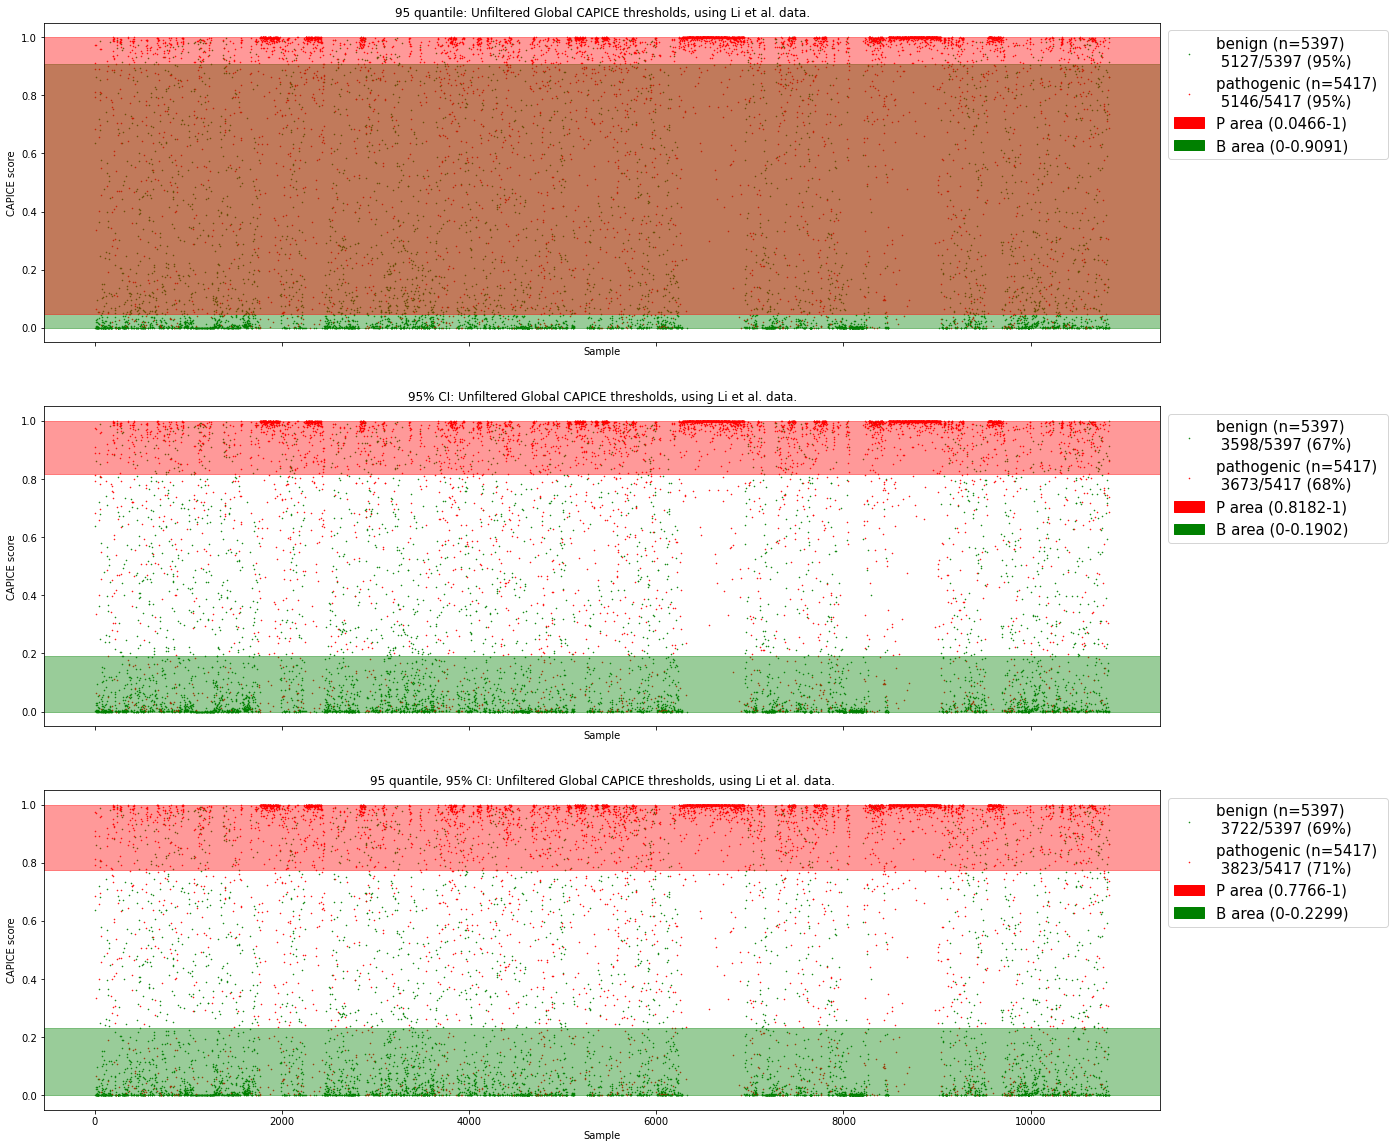

<Figure size 432x288 with 0 Axes>

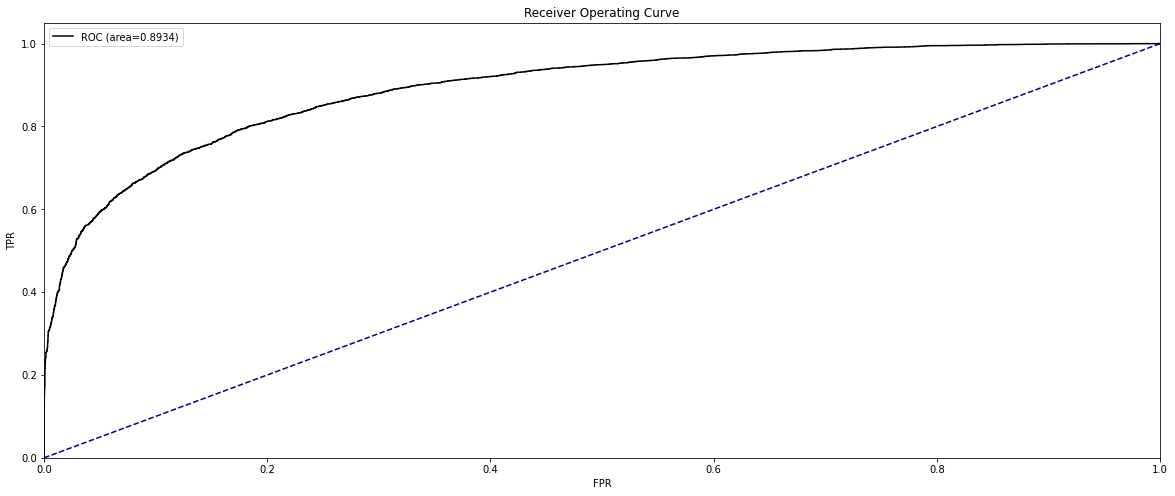

<Figure size 432x288 with 0 Axes>

In [13]:
plot_thresholds(merge=merge, title='Unfiltered Global CAPICE thresholds, using Li et al. data.', plot_auc=True)

In [14]:
labels_new = pd.read_csv('/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Thresholds/validate.csv.gz')
labels_new

/home/rjsietsma/PycharmProjects/capice_updatr/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


chr     pos ref alt clinsig                               review  \
0        1  865584   G   A      LB  criteria_provided,_single_submitter   
1        1  865627   T   C      LB  criteria_provided,_single_submitter   
2        1  866422   C   T      LB  criteria_provided,_single_submitter   
3        1  871192   C   T      LB  criteria_provided,_single_submitter   
4        1  874416   G   A      LB  criteria_provided,_single_submitter   
...     ..     ...  ..  ..     ...                                  ...   
124239  MT   15926   C   T      LB  criteria_provided,_single_submitter   
124240  MT   15941   T   C      LB  criteria_provided,_single_submitter   
124241  MT   15944   T   C      LB  criteria_provided,_single_submitter   
124242  MT   15951   A   G      LB  criteria_provided,_single_submitter   
124243  MT   15990   C   T      LP       no_assertion_criteria_provided   

        stars   source    gene            merge_col    max_af  
0           1  clinvar  SAMD11  1_865584_G_A_SAMD11  0.039300  
1           1  clinvar  SAMD11  1_865627_T_C_SAMD11  0.000061  
2           1  clinvar  SAMD11  1_866422_C_T_SAMD11  0.015820  
3           1  clinvar  SAMD11  1_871192_C_T_SAMD11  0.005193  
4           1  clinvar  SAMD11  1_874416_G_A_SAMD11  0.000032  
...       ...      ...     ...                  ...       ...  
124239      1  clinvar   MT-TT   MT_15926_C_T_MT-TT  0.000000  
124240      1  clinvar   MT-TT   MT_15941_T_C_MT-TT  0.000000  
124241      1  clinvar   MT-TT   MT_15944_T_C_MT-TT  0.000000  
124242      1  clinvar   MT-TT   MT_15951_A_G_MT-TT  0.000000  
124243      0  clinvar   MT-TP   MT_15990_C_T_MT-TP  0.000000  

[124244 rows x 11 columns]

In [15]:
labels_new['chr_pos_ref_alt'] = labels_new[['chr', 'pos', 'ref', 'alt']].astype(str).agg('_'.join, axis=1)
labels_new

chr     pos ref alt clinsig                               review  \
0        1  865584   G   A      LB  criteria_provided,_single_submitter   
1        1  865627   T   C      LB  criteria_provided,_single_submitter   
2        1  866422   C   T      LB  criteria_provided,_single_submitter   
3        1  871192   C   T      LB  criteria_provided,_single_submitter   
4        1  874416   G   A      LB  criteria_provided,_single_submitter   
...     ..     ...  ..  ..     ...                                  ...   
124239  MT   15926   C   T      LB  criteria_provided,_single_submitter   
124240  MT   15941   T   C      LB  criteria_provided,_single_submitter   
124241  MT   15944   T   C      LB  criteria_provided,_single_submitter   
124242  MT   15951   A   G      LB  criteria_provided,_single_submitter   
124243  MT   15990   C   T      LP       no_assertion_criteria_provided   

        stars   source    gene            merge_col    max_af chr_pos_ref_alt  
0           1  clinvar  SAMD11  1_865584_G_A_SAMD11  0.039300    1_865584_G_A  
1           1  clinvar  SAMD11  1_865627_T_C_SAMD11  0.000061    1_865627_T_C  
2           1  clinvar  SAMD11  1_866422_C_T_SAMD11  0.015820    1_866422_C_T  
3           1  clinvar  SAMD11  1_871192_C_T_SAMD11  0.005193    1_871192_C_T  
4           1  clinvar  SAMD11  1_874416_G_A_SAMD11  0.000032    1_874416_G_A  
...       ...      ...     ...                  ...       ...             ...  
124239      1  clinvar   MT-TT   MT_15926_C_T_MT-TT  0.000000    MT_15926_C_T  
124240      1  clinvar   MT-TT   MT_15941_T_C_MT-TT  0.000000    MT_15941_T_C  
124241      1  clinvar   MT-TT   MT_15944_T_C_MT-TT  0.000000    MT_15944_T_C  
124242      1  clinvar   MT-TT   MT_15951_A_G_MT-TT  0.000000    MT_15951_A_G  
124243      0  clinvar   MT-TP   MT_15990_C_T_MT-TP  0.000000    MT_15990_C_T  

[124244 rows x 12 columns]

In [16]:
data_new = pd.read_csv('/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Thresholds/cadd_14_37_annotated_validate_capice.tsv.gz', sep='\t')
data_new

chr_pos_ref_alt    GeneName        FeatureID       Consequence  \
0         1_865584_G_A  AL645608.1  ENST00000598827    NON_SYNONYMOUS   
1         1_865584_G_A      SAMD11  ENST00000342066    NON_SYNONYMOUS   
2         1_865627_T_C  AL645608.1  ENST00000598827    NON_SYNONYMOUS   
3         1_865627_T_C      SAMD11  ENST00000342066        SYNONYMOUS   
4         1_866422_C_T      SAMD11  ENST00000342066        SYNONYMOUS   
...                ...         ...              ...               ...   
189939   Y_2655633_A_T  RNASEH2CP1  ENST00000454281          UPSTREAM   
189940   Y_6931939_A_T       TBL1Y  ENST00000383032    NON_SYNONYMOUS   
189941   Y_6932115_G_A       TBL1Y  ENST00000383032    NON_SYNONYMOUS   
189942   Y_6932191_G_C       TBL1Y  ENST00000383032  CANONICAL_SPLICE   
189943   Y_9305041_C_G         NaN              NaN        INTERGENIC   

        probabilities  
0            0.045694  
1            0.021831  
2            0.000309  
3            0.000179  
4            0.000172  
...               ...  
189939       0.000389  
189940       0.008996  
189941       0.000038  
189942       0.063489  
189943       0.000174  

[189944 rows x 5 columns]

In [17]:
train_data = pd.read_csv('/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Thresholds/train.txt.gz', sep='\t')
train_data

/home/rjsietsma/PycharmProjects/capice_updatr/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,55,63,73,107,109,110,111,112,113,130) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#Chrom  Allergy/Immunology/Infectious Alt          AnnoType  \
0          14                          False   G  CodingTranscript   
1          20                          False   T  CodingTranscript   
2          20                          False   C  CodingTranscript   
3          20                          False   A  CodingTranscript   
4          20                          False   A        Intergenic   
...       ...                            ...  ..               ...   
334596     17                          False   A  CodingTranscript   
334597     17                          False   T  CodingTranscript   
334598     10                          False   T  CodingTranscript   
334599      2                          False   T  CodingTranscript   
334600      5                          False   T  CodingTranscript   

        Audiologic/Otolaryngologic  Biochemical         CCDS  CDSpos  \
0                            False        False   CCDS9787.1   806.0   
1                             True        False  CCDS13112.1  1899.0   
2                             True        False  CCDS13112.1  2118.0   
3                             True        False  CCDS13112.1  1586.0   
4                             True        False          NaN     NaN   
...                            ...          ...          ...     ...   
334596                       False        False  CCDS32642.1  1563.0   
334597                       False        False  CCDS32642.1  2029.0   
334598                       False        False   CCDS7431.1  1216.0   
334599                       False        False   CCDS2382.1  2998.0   
334600                       False        False   CCDS3952.1  1221.0   

        Cardiovascular              ConsDetail  ...  revel sift   source  \
0                False              frameshift  ...    NaN  NaN     vkgl   
1                 True  frameshift,stop_gained  ...    NaN  NaN     vkgl   
2                 True              frameshift  ...    NaN  NaN     vkgl   
3                 True              frameshift  ...    NaN  NaN     vkgl   
4                 True              downstream  ...    NaN  NaN     vkgl   
...                ...                     ...  ...    ...  ...      ...   
334596           False             stop_gained  ...    NaN  NaN  unknown   
334597           False             stop_gained  ...    NaN  NaN  unknown   
334598           False             stop_gained  ...    NaN  NaN  unknown   
334599           False             stop_gained  ...    NaN  NaN  unknown   
334600           False             stop_gained  ...    NaN  NaN  unknown   

        tOverlapMotifs  targetScan  to_be_deleted  verPhCons verPhyloP inTest  \
0                  NaN         NaN          False      1.000     5.843  False   
1                  NaN         NaN          False      1.000     4.670  False   
2                  NaN         NaN          False      1.000     5.043  False   
3                  NaN         NaN          False      1.000     6.221  False   
4                  NaN         NaN          False      1.000     6.368  False   
...                ...         ...            ...        ...       ...    ...   
334596             NaN         NaN          False      1.000     6.031  False   
334597             NaN         NaN          False      1.000     4.100  False   
334598             NaN         NaN          False      1.000     5.852  False   
334599             NaN         NaN          False      0.031     2.213  False   
334600             NaN         NaN          False      1.000     0.528  False   

        sample_weight  
0                 1.0  
1                 1.0  
2                 1.0  
3                 1.0  
4                 1.0  
...               ...  
334596            0.8  
334597            0.8  
334598            0.8  
334599            0.8  
334600            0.8  

[334601 rows x 152 columns]

In [18]:
merge = data_new.merge(labels_new[['chr_pos_ref_alt', 'clinsig', 'stars']])
merge[['chr', 'pos', 'ref', 'alt']] = merge['chr_pos_ref_alt'].str.split('_', expand=True)
merge.drop(columns='chr_pos_ref_alt', inplace=True)
merge['binarized_label'] = 0
merge.loc[merge[merge['clinsig'] == 'LP'].index, 'binarized_label'] = 1
merge_original_columns = merge.columns
merge

GeneName        FeatureID       Consequence  probabilities clinsig  \
0       AL645608.1  ENST00000598827    NON_SYNONYMOUS       0.045694      LB   
1           SAMD11  ENST00000342066    NON_SYNONYMOUS       0.021831      LB   
2       AL645608.1  ENST00000598827    NON_SYNONYMOUS       0.000309      LB   
3           SAMD11  ENST00000342066        SYNONYMOUS       0.000179      LB   
4           SAMD11  ENST00000342066        SYNONYMOUS       0.000172      LB   
...            ...              ...               ...            ...     ...   
206444  RNASEH2CP1  ENST00000454281          UPSTREAM       0.000389      LP   
206445       TBL1Y  ENST00000383032    NON_SYNONYMOUS       0.008996      LP   
206446       TBL1Y  ENST00000383032    NON_SYNONYMOUS       0.000038      LB   
206447       TBL1Y  ENST00000383032  CANONICAL_SPLICE       0.063489      LB   
206448         NaN              NaN        INTERGENIC       0.000174      LB   

        stars chr      pos ref alt  binarized_label  
0           1   1   865584   G   A                0  
1           1   1   865584   G   A                0  
2           1   1   865627   T   C                0  
3           1   1   865627   T   C                0  
4           1   1   866422   C   T                0  
...       ...  ..      ...  ..  ..              ...  
206444      0   Y  2655633   A   T                1  
206445      0   Y  6931939   A   T                1  
206446      1   Y  6932115   G   A                0  
206447      1   Y  6932191   G   C                0  
206448      1   Y  9305041   C   G                0  

[206449 rows x 11 columns]

In [19]:
merge['chr_pos_ref_alt_gene'] = merge[['chr', 'pos', 'ref', 'alt', 'GeneName']].astype(str).agg('_'.join, axis=1)
merge = merge.append(train_data)
merge.drop_duplicates(subset=['chr_pos_ref_alt_gene', 'binarized_label'], inplace=True)
merge = merge[merge['chr'].notnull()][merge_original_columns]
merge.index = range(0, merge.shape[0])
merge['sample'] = merge.index
merge

GeneName        FeatureID       Consequence  probabilities clinsig  \
0       AL645608.1  ENST00000598827    NON_SYNONYMOUS       0.045694      LB   
1           SAMD11  ENST00000342066    NON_SYNONYMOUS       0.021831      LB   
2       AL645608.1  ENST00000598827    NON_SYNONYMOUS       0.000309      LB   
3           SAMD11  ENST00000342066        SYNONYMOUS       0.000179      LB   
4           SAMD11  ENST00000342066        SYNONYMOUS       0.000172      LB   
...            ...              ...               ...            ...     ...   
187986  RNASEH2CP1  ENST00000454281          UPSTREAM       0.000389      LP   
187987       TBL1Y  ENST00000383032    NON_SYNONYMOUS       0.008996      LP   
187988       TBL1Y  ENST00000383032    NON_SYNONYMOUS       0.000038      LB   
187989       TBL1Y  ENST00000383032  CANONICAL_SPLICE       0.063489      LB   
187990         NaN              NaN        INTERGENIC       0.000174      LB   

        stars chr      pos ref alt  binarized_label  sample  
0         1.0   1   865584   G   A                0       0  
1         1.0   1   865584   G   A                0       1  
2         1.0   1   865627   T   C                0       2  
3         1.0   1   865627   T   C                0       3  
4         1.0   1   866422   C   T                0       4  
...       ...  ..      ...  ..  ..              ...     ...  
187986    0.0   Y  2655633   A   T                1  187986  
187987    0.0   Y  6931939   A   T                1  187987  
187988    1.0   Y  6932115   G   A                0  187988  
187989    1.0   Y  6932191   G   C                0  187989  
187990    1.0   Y  9305041   C   G                0  187990  

[187991 rows x 12 columns]

A total of: 918 CNVs have been filtered out.


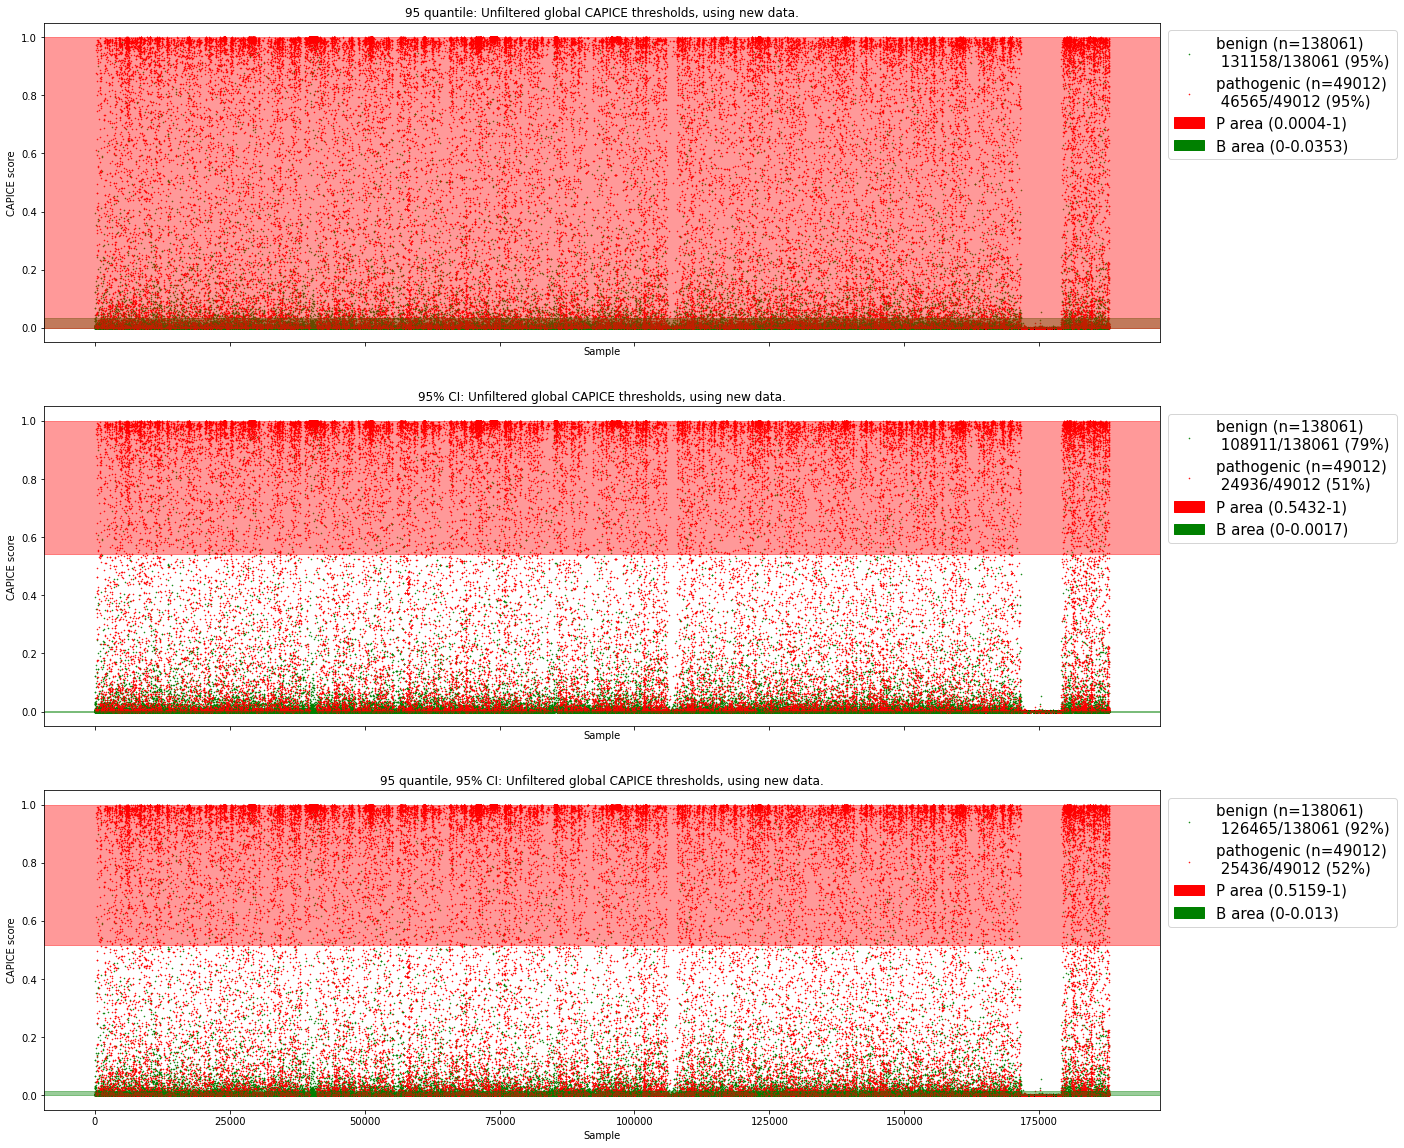

<Figure size 432x288 with 0 Axes>

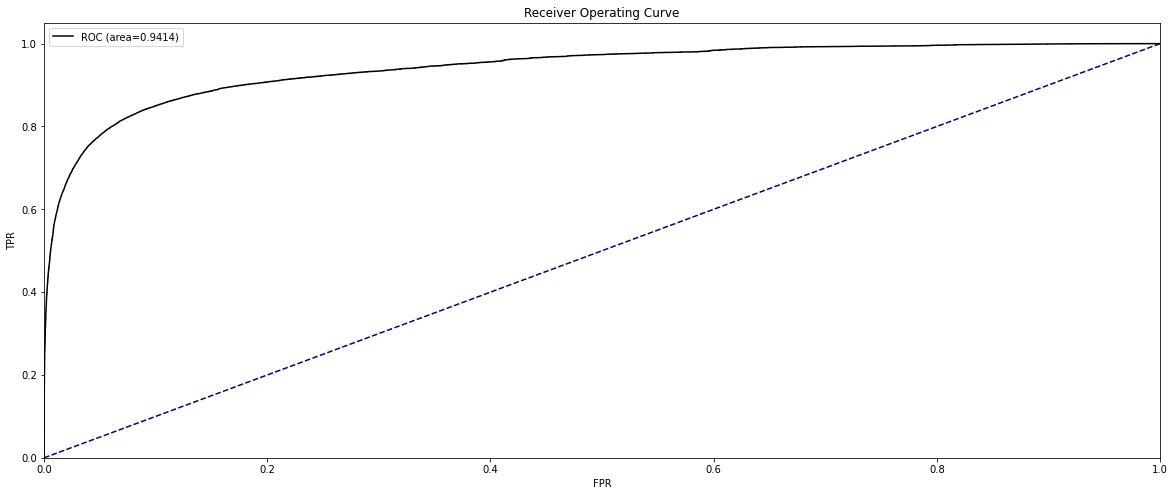

<Figure size 432x288 with 0 Axes>

In [20]:
plot_thresholds(merge=merge, title='Unfiltered global CAPICE thresholds, using new data.', plot_auc=True)

A total of: 494 CNVs have been filtered out.


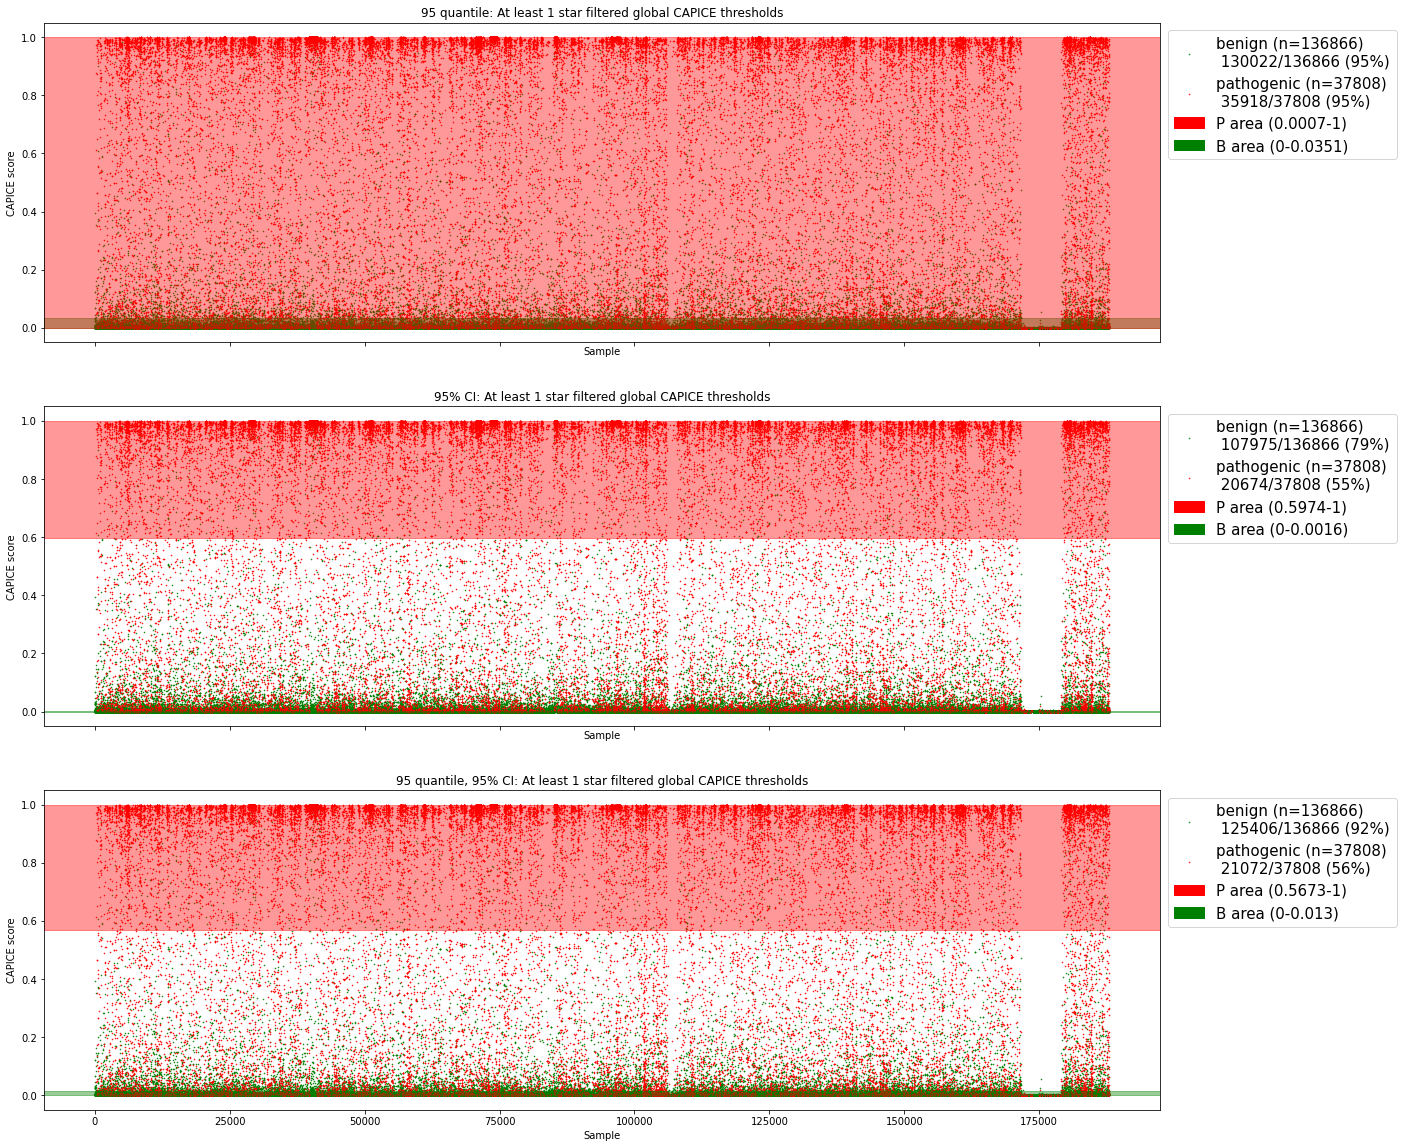

<Figure size 432x288 with 0 Axes>

In [21]:
plot_thresholds(merge=merge, title='At least 1 star filtered global CAPICE thresholds', stars=1)

A total of: 55 CNVs have been filtered out.


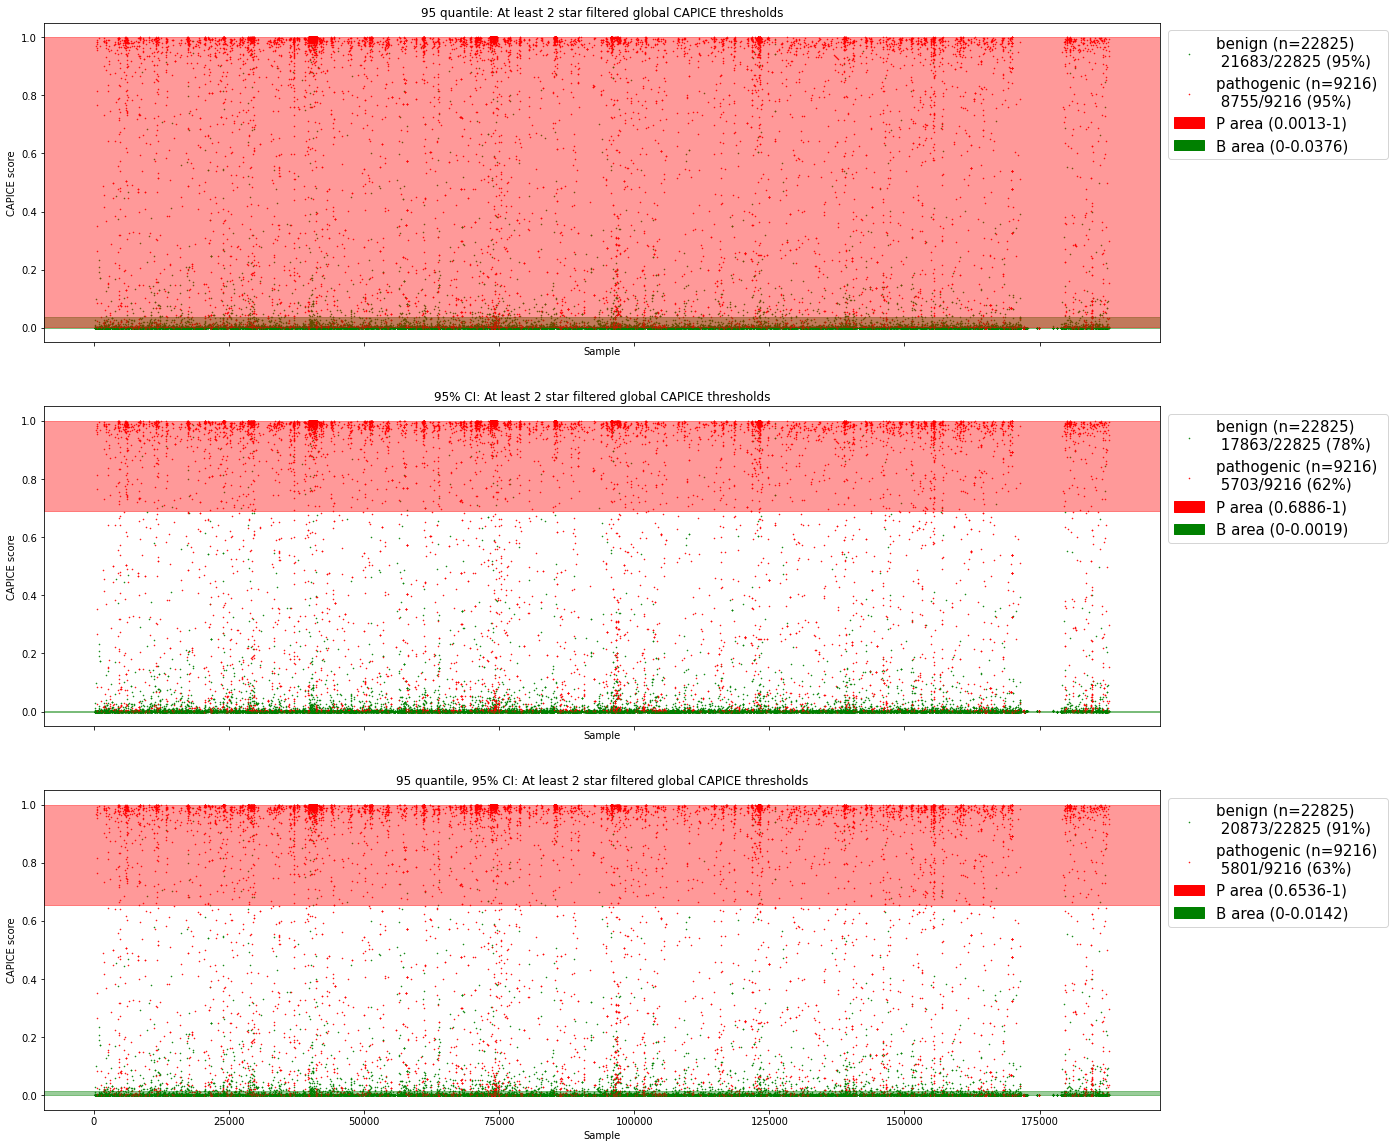

<Figure size 432x288 with 0 Axes>

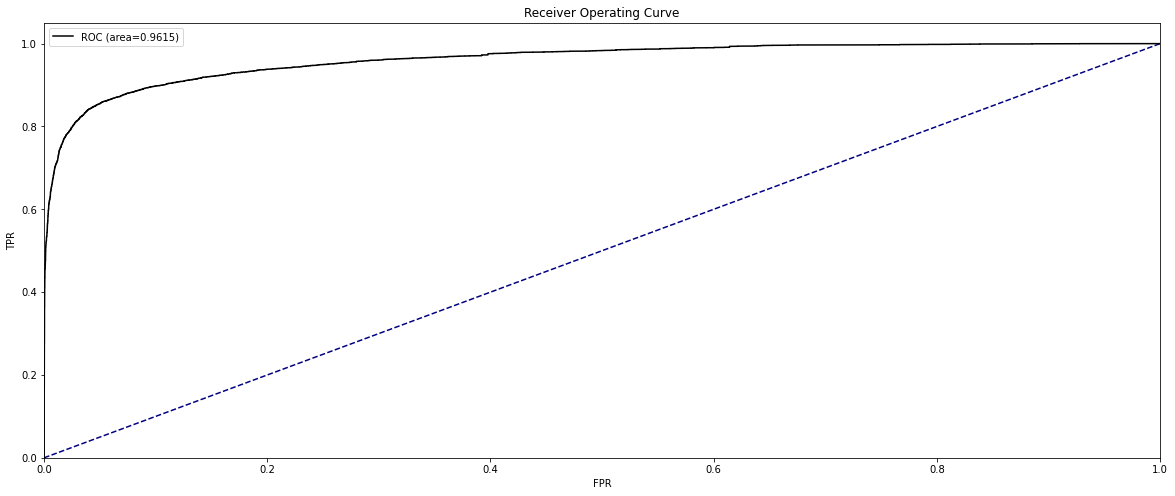

<Figure size 432x288 with 0 Axes>

In [22]:
plot_thresholds(merge=merge, title='At least 2 star filtered global CAPICE thresholds', stars=2, plot_auc=True)

In [23]:
cgd = pd.read_csv('/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Thresholds/CGD.txt.gz', sep='\t', low_memory=False)
cgd

#GENE  HGNC ID  ENTREZ GENE ID  \
0        A2M        7               2   
1      A2ML1    23336          144568   
2     A4GALT    18149           53947   
3       AAAS    13666            8086   
4      AAGAB    25662           79719   
...      ...      ...             ...   
4245     ZP1    13187           22917   
4246     ZP2    13188            7783   
4247     ZP3    13189            7784   
4248    ZPR1    13051            8882   
4249  ZSWIM6    29316           57688   

                                              CONDITION INHERITANCE  \
0                      Alpha-2-macroglobulin deficiency          AD   
1                       Otitis media, susceptibility to          AD   
2                              Blood group, P1PK system          BG   
3            Achalasia-addisonianism-alacrimia syndrome          AR   
4           Keratoderma, palmoplantar, punctate type IA          AD   
...                                                 ...         ...   
4245                         Oocyte maturation defect 1          AR   
4246                         Oocyte maturation defect 6          AR   
4247                         Oocyte maturation defect 3          AD   
4248  Growth restriction, hypoplastic kidneys, alope...          AR   
4249  Acromelic frontonasal dysostosis; Neurodevelop...          AD   

      AGE GROUP ALLELIC CONDITIONS  \
0           NaN                NaN   
1     Pediatric                NaN   
2     Pediatric                NaN   
3     Pediatric                NaN   
4           NaN                NaN   
...         ...                ...   
4245        NaN                NaN   
4246        NaN                NaN   
4247        NaN                NaN   
4248  Pediatric                NaN   
4249        NaN                NaN   

                               MANIFESTATION CATEGORIES  \
0                                               General   
1                         Allergy/Immunology/Infectious   
2                                           Hematologic   
3     Dermatologic; Endocrine; Gastrointestinal; Neu...   
4                                          Dermatologic   
...                                                 ...   
4245                                          Obstetric   
4246                                          Obstetric   
4247                                          Obstetric   
4248  Audiologic/Otolaryngologic; Craniofacial; Dent...   
4249          Craniofacial; Musculoskeletal; Neurologic   

                INTERVENTION CATEGORIES  \
0                               General   
1         Allergy/Immunology/Infectious   
2                           Hematologic   
3                             Endocrine   
4                               General   
...                                 ...   
4245                            General   
4246                            General   
4247                            General   
4248  Audiologic/Otolaryngologic; Renal   
4249                            General   

                                               COMMENTS  \
0     Variants have been implicated in pulmonary dis...   
1                                                   NaN   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
4245                                                NaN   
4246                                                NaN   
4247                                                NaN   
4248                                                NaN   
4249                                                NaN   

                                 INTERVENTION/RATIONALE  \
0     The clinical consequences of variants are unclear   
1     Individuals may have increased susceptibility ...   
2     Variants associated with a blood group may be ...   
3     Surveillance and treatment/

In [24]:
filtered_merge = merge[merge['GeneName'].isin(cgd['#GENE'])]
filtered_merge.reset_index(drop=True, inplace=True)
filtered_merge

GeneName        FeatureID       Consequence  probabilities clinsig  \
0         ISG15  ENST00000379389        SYNONYMOUS       0.001639      LB   
1         ISG15  ENST00000379389        SYNONYMOUS       0.000066      LB   
2         ISG15  ENST00000379389       STOP_GAINED       0.010289      LP   
3         ISG15  ENST00000379389        SYNONYMOUS       0.000130      LB   
4         ISG15  ENST00000379389        SYNONYMOUS       0.000106      LB   
...         ...              ...               ...            ...     ...   
110207      SRY  ENST00000383070    NON_SYNONYMOUS       0.000441      LP   
110208      SRY  ENST00000383070       STOP_GAINED       0.004331      LP   
110209    TBL1Y  ENST00000383032    NON_SYNONYMOUS       0.008996      LP   
110210    TBL1Y  ENST00000383032    NON_SYNONYMOUS       0.000038      LB   
110211    TBL1Y  ENST00000383032  CANONICAL_SPLICE       0.063489      LB   

        stars chr      pos ref alt  binarized_label  sample  
0         1.0   1   949399   C   T                0     118  
1         1.0   1   949495   G   T                0     120  
2         0.0   1   949523   C   T                1     122  
3         1.0   1   949597   C   T                0     124  
4         1.0   1   949696   C   T                0     126  
...       ...  ..      ...  ..  ..              ...     ...  
110207    0.0   Y  2655592   C   T                1  187981  
110208    0.0   Y  2655633   A   T                1  187984  
110209    0.0   Y  6931939   A   T                1  187987  
110210    1.0   Y  6932115   G   A                0  187988  
110211    1.0   Y  6932191   G   C                0  187989  

[110212 rows x 12 columns]

A total of: 486 CNVs have been filtered out.


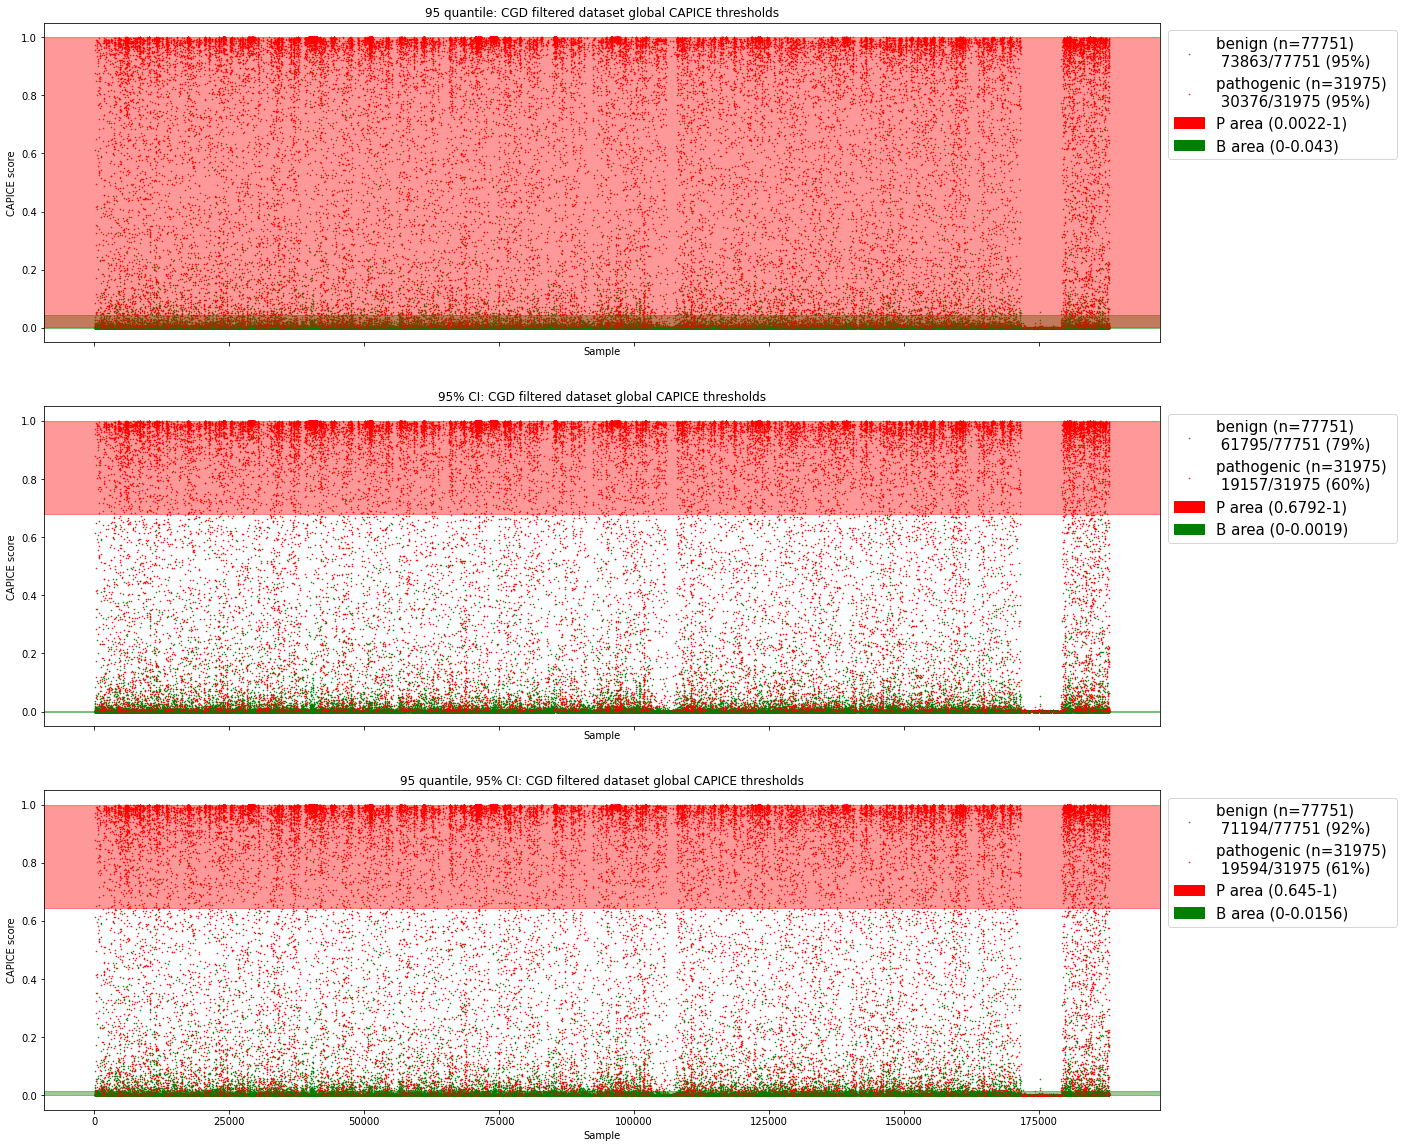

<Figure size 432x288 with 0 Axes>

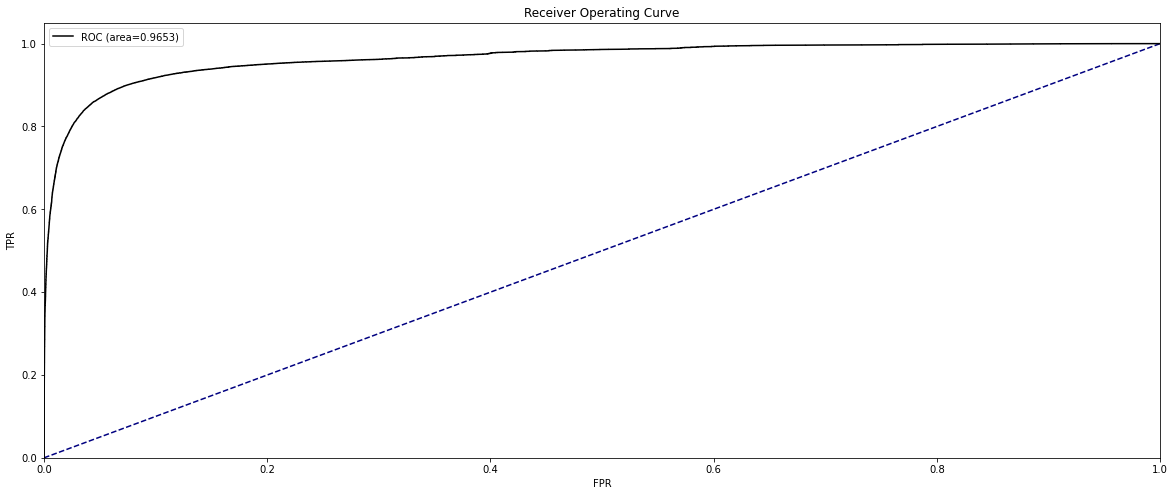

<Figure size 432x288 with 0 Axes>

In [25]:
plot_thresholds(filtered_merge, title='CGD filtered dataset global CAPICE thresholds', plot_auc = True)

A total of: 266 CNVs have been filtered out.


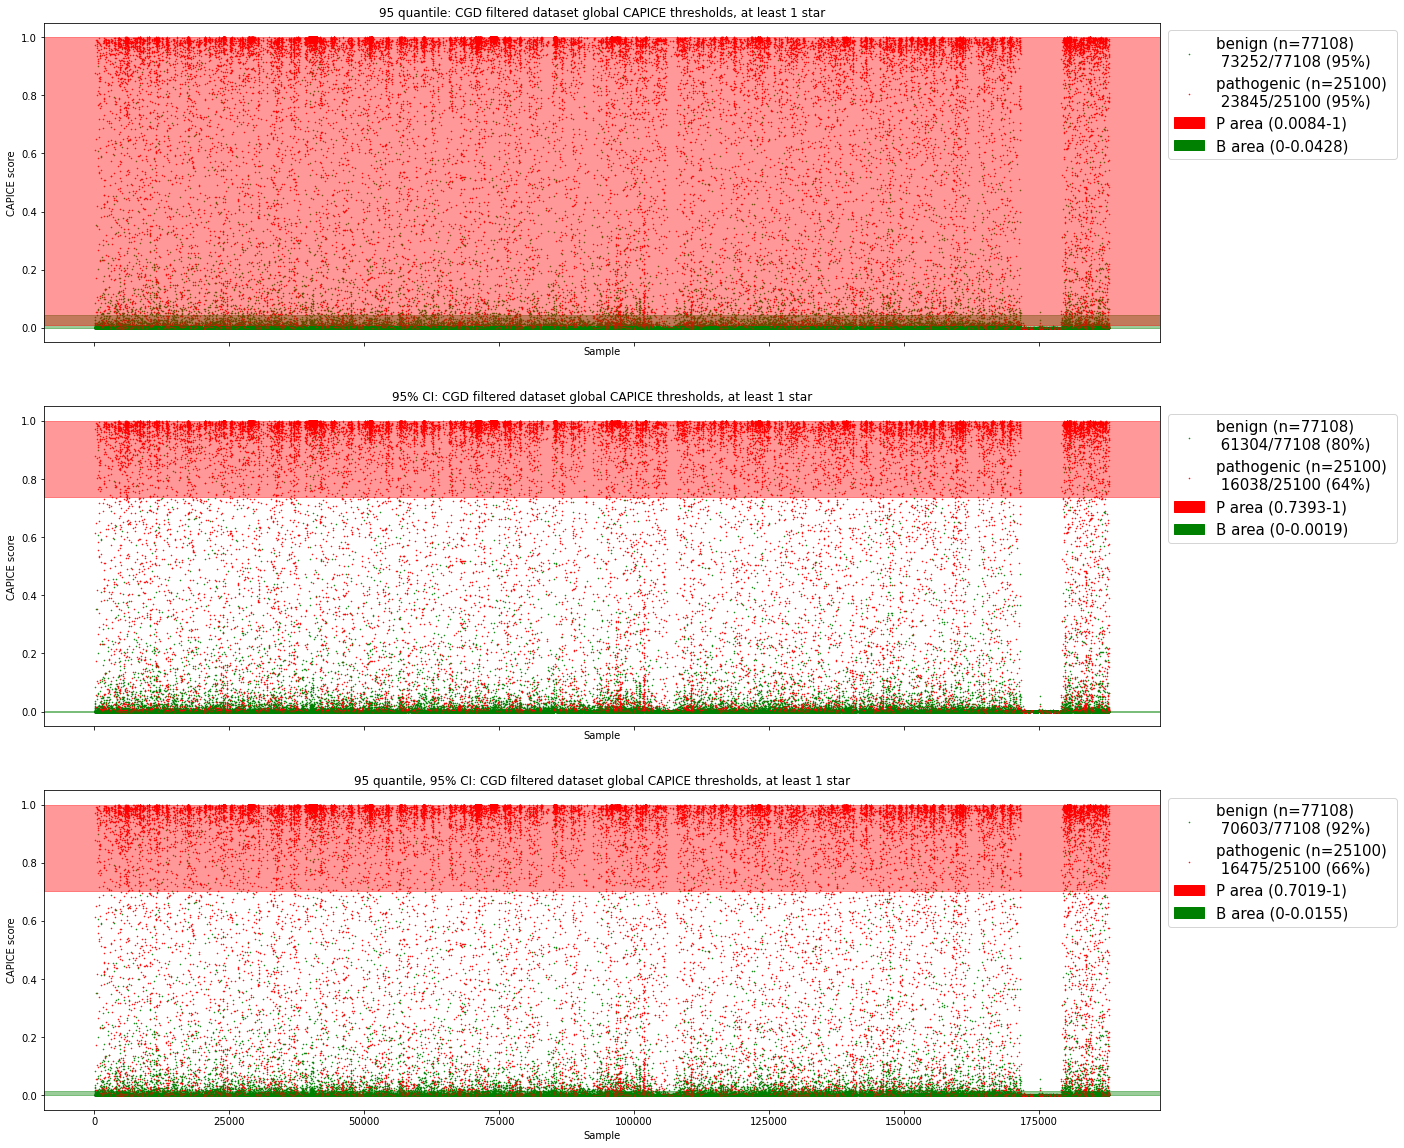

<Figure size 432x288 with 0 Axes>

In [26]:
plot_thresholds(filtered_merge, title='CGD filtered dataset global CAPICE thresholds, at least 1 star', stars=1)

A total of: 33 CNVs have been filtered out.


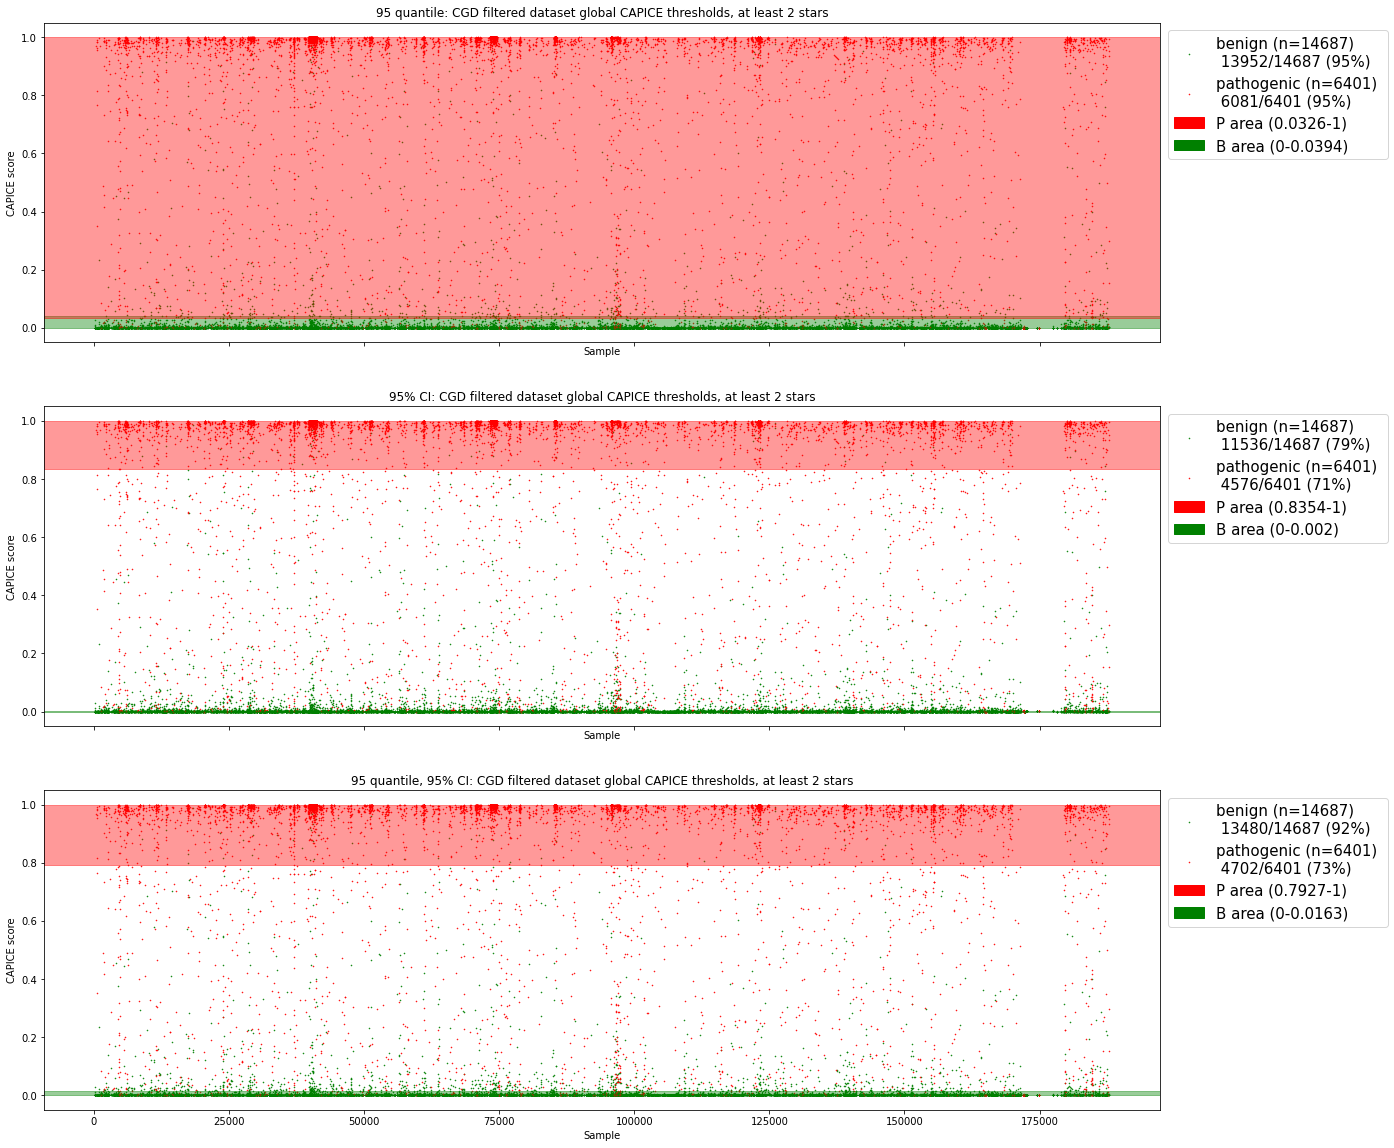

<Figure size 432x288 with 0 Axes>

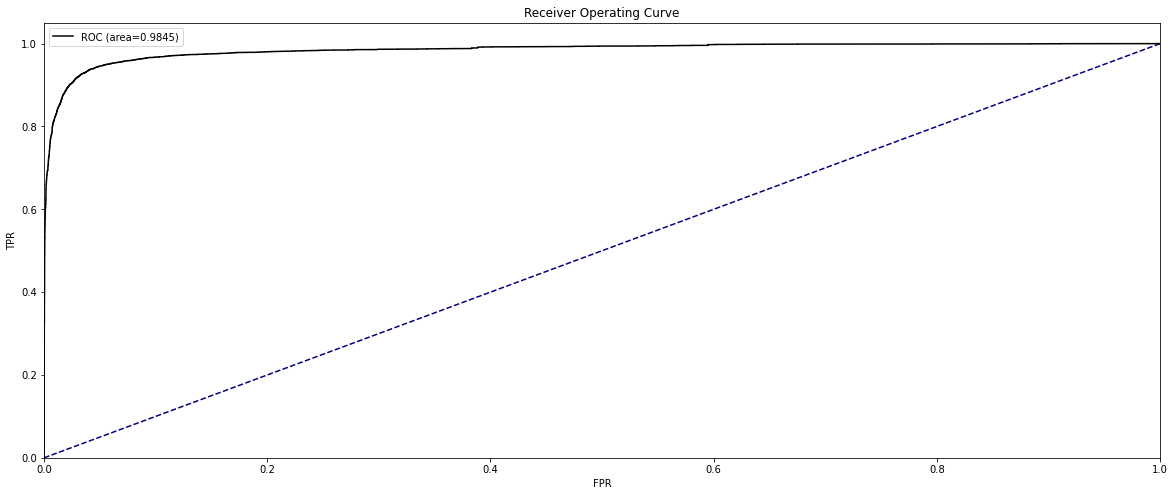

<Figure size 432x288 with 0 Axes>

In [27]:
plot_thresholds(filtered_merge, title='CGD filtered dataset global CAPICE thresholds, at least 2 stars', stars=2, plot_auc = True)

In [28]:
if not os.path.exists('/home/rjsietsma/PycharmProjects/capice_updatr/per_gene_thresholds'):
    os.makedirs('/home/rjsietsma/PycharmProjects/capice_updatr/per_gene_thresholds')

# Un-markdown when you want per gene threshold plots

In [29]:
thresholds_loc = '/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Thresholds/thresholds.csv.gz'
thresholds = pd.DataFrame(columns=['pathogenic_quantile', 'n_pathogenic_total', 'n_pathogenic_correct', 'benign_quantile', 'n_benign_total', 'n_benign_correct', 'final_confidence', 'gene_name'])
if not os.path.isfile(thresholds_loc):
    thresholds.to_csv(thresholds_loc, index=False, compression='gzip')
    print('Created thresholds.csv.gz')
thresholds

Empty DataFrame
Columns: [pathogenic_quantile, n_pathogenic_total, n_pathogenic_correct, benign_quantile, n_benign_total, n_benign_correct, final_confidence, gene_name]
Index: []

In [30]:
genes_of_interest = ['BRCA1', 'COL7A1', 'TTN', 'MEFV']
merge = merge[merge['GeneName'].isin(genes_of_interest)]
merge.reset_index(drop=True, inplace=True)
merge._is_copy = None

In [31]:
merge

GeneName        FeatureID     Consequence  probabilities clinsig  stars  \
0        MEFV  ENST00000219596      3PRIME_UTR       0.000022      LB    2.0   
1        MEFV  ENST00000219596      3PRIME_UTR       0.000039      LB    2.0   
2        MEFV  ENST00000219596      3PRIME_UTR       0.000066      LB    1.0   
3        MEFV  ENST00000219596  NON_SYNONYMOUS       0.026024      LP    1.0   
4        MEFV  ENST00000219596      SYNONYMOUS       0.000977      LB    2.0   
...       ...              ...             ...            ...     ...    ...   
3308   COL7A1  ENST00000328333      SYNONYMOUS       0.000047      LB    1.0   
3309   COL7A1  ENST00000328333     SPLICE_SITE       0.000078      LB    1.0   
3310   COL7A1  ENST00000328333      SYNONYMOUS       0.002329      LB    1.0   
3311   COL7A1  ENST00000328333        UPSTREAM       0.085251      LP    0.0   
3312   COL7A1  ENST00000328333        UPSTREAM       0.015461      LB    1.0   

     chr       pos ref alt  binarized_label  sample  
0     16   3292874   C   T                0   58898  
1     16   3292896   C   T                0   58900  
2     16   3293120   G   C                0   58901  
3     16   3293206   G   A                1   58902  
4     16   3293216   G   A                0   58903  
...   ..       ...  ..  ..              ...     ...  
3308   3  48631971   C   T                0  124926  
3309   3  48631986   G   A                0  124931  
3310   3  48632566   C   A                0  124932  
3311   3  48632780   G   A                1  124936  
3312   3  48637143   C   T                0  124939  

[3313 rows x 12 columns]

In [35]:
merge[merge['stars'] > 2]['GeneName'].value_counts()

BRCA1    621
Name: GeneName, dtype: int64

In [49]:
total_genes = merge['GeneName'].unique().size
current = 0
current_confidence = 100
reset_timer = time.time()
    
dot_size = 0.3
n_decimals = 4

ci = 90
track_changes = False

for gene in merge['GeneName'].unique():
    # Timer
    current += 1
    curr_time = time.time()
    if curr_time - reset_timer > 10:
        print(f'Still processing, currently on {current}/{total_genes}')
        reset_timer = time.time()
        
    # Subset genes
    subset = merge[merge['GeneName'] == gene]
    
    # Check if benign samples are present
    benign_subset = subset[subset['binarized_label'] == 0]
    if benign_subset.shape[0] == 0:
        total_genes -= 1
        current -= 1
        current_confidence = 100
        continue
        
    # Check if pathogenic samples are present
    patho_subset = subset[subset['binarized_label'] == 1]
    if patho_subset.shape[0] == 0:
        total_genes -= 1
        current -= 1
        current_confidence = 100
        continue
        
    # Checks passed, check if Gene is not already present in directory
    if os.path.isfile(f'/home/rjsietsma/PycharmProjects/capice_updatr/per_gene_thresholds/{gene[0]}/{gene}.png') and track_changes:
        continue
        
    # If enough samples are present, continue to calculate the sliding confidence threshold.
    for i in range(100): 
        # Calculate 95% CI around 95 quantile benign area        
        benign_scores = benign_subset['probabilities']
        percentile_benign = np.percentile(benign_scores, (current_confidence))
    
        # Calculate 95% CI around 5 quantile pathogenic area (since pathogenic runs from 1 to 0)
        patho_scores = patho_subset['probabilities']
        percentile_patho = np.percentile(patho_scores, (100 - current_confidence))
    
        if percentile_patho > percentile_benign:
            
            if ci:
                _, _, b_ci_upper_threshold = calc_ci(benign_scores[benign_scores <= percentile_benign], z=z_scores[ci]) 
                p_ci_lower_threshold, _, _ = calc_ci(patho_scores[patho_scores >= percentile_patho], z=z_scores[ci])
            else:
                b_ci_upper_threshold = percentile_benign
                p_ci_lower_threshold = percentile_patho
            
            pathogenic_threshold = p_ci_lower_threshold
            benign_threshold = b_ci_upper_threshold
            
            fig, axes = plt.subplots(1,1,figsize=(20,8))
            # Plot benign area from 0 to upper CI
            axes.axhspan(0,
                        benign_threshold,
                        0,
                        1,
                        color='green',
                        alpha=0.4
                       )
    
            # Metrics for benign
            n_benign_correct = benign_subset[benign_subset['probabilities'] <= benign_threshold].shape[0]
            n_benign_tot = benign_subset.shape[0]
    
            # Plotting the samples with the metrics
            axes.scatter(benign_subset['sample'],
                        benign_subset['probabilities'],
                        s=dot_size,
                        color='green',
                        label=f'benign (n={n_benign_tot}) \n {n_benign_correct}/{n_benign_tot} ({round(n_benign_correct/n_benign_tot*100)}%)'
                        )

            # Plot pathogenic area from lower CI to 1
            axes.axhspan(pathogenic_threshold,
                        1,
                        0,
                        1,
                        color='red',
                        alpha=0.4
                       )
        
            # Metrics for pathogenic
            n_patho_correct = patho_subset[patho_subset['probabilities'] >= pathogenic_threshold].shape[0]
            n_patho_tot = patho_subset.shape[0]
    
            # plotting the samples with metrics
            axes.scatter(patho_subset['sample'],
                        patho_subset['probabilities'],
                        s=dot_size,
                        color='red',
                        label=f'pathogenic (n={n_patho_tot}) \n {n_patho_correct}/{n_patho_tot} ({round(n_patho_correct/n_patho_tot*100)}%)'
                       )

            handles, labels = axes.get_legend_handles_labels()

            red_patch = mpatches.Patch(color='red', label=f'P area ({round(pathogenic_threshold, n_decimals)}-1)')
            handles.append(red_patch)
            green_patch = mpatches.Patch(color='green', label=f'B area (0-{round(benign_threshold, n_decimals)})')
            handles.append(green_patch)
            axes.legend(bbox_to_anchor=(1.0,1.0), handles=handles)

            axes.set_ylabel('CAPICE score')
            axes.set_xlabel('Sample')
            additional_title = ''
            if ci:
                additional_title = f' (CI={ci})'
            axes.set_title(f'CAPICE threshold calculations on {gene} (CONFIDENCE={current_confidence}%){additional_title}')
            
            export_loc = f'/home/rjsietsma/PycharmProjects/capice_updatr/per_gene_thresholds/{gene[0]}'
            if ci:
                export_loc = f'/home/rjsietsma/PycharmProjects/capice_updatr/POC_thresholds/{ci}'
    
            if not os.path.exists(export_loc):
                os.makedirs(export_loc)
        
            save_to_thresholds = [percentile_patho, n_patho_tot, n_patho_correct, percentile_benign, n_benign_tot, n_benign_correct, current_confidence, gene]
            threshold_series = pd.Series(save_to_thresholds, index=thresholds.columns)
            if track_changes:
                thresholds.append(threshold_series, ignore_index=True).to_csv(thresholds_loc, mode='a', index=False, compression='gzip', header=False)

            plt.savefig(f'{export_loc}/{gene}.png')
            plt.figure().clear()
            plt.close('all')
            plt.cla()
            plt.clf()
            break
        else:
            current_confidence -= 1
    gc.collect()
    current_confidence = 100

print(f"Done. Total processed: {current} (out of {merge['GeneName'].unique().size} total)")

Done. Total processed: 4 (out of 4 total)


<Figure size 432x288 with 0 Axes>

# /Un-markdown

In [4]:
thresholds = pd.read_csv('/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/thresholds.csv.gz')
thresholds

pathogenic_quantile  n_pathogenic_total  n_pathogenic_correct  \
0                0.010289                   1                     1   
1                0.001882                   1                     1   
2                0.005215                   6                     5   
3                0.006223                   2                     1   
4                0.001109                   8                     8   
...                   ...                 ...                   ...   
5133             0.296765                   3                     3   
5134             0.003777                   8                     2   
5135             0.003777                   8                     2   
5136             0.000684                   8                     7   
5137             0.008996                   1                     1   

      benign_quantile  n_benign_total  n_benign_correct  final_confidence  \
0            0.001639               7                 7               100   
1            0.001832               7                 7               100   
2            0.004292             121               106                88   
3            0.002617              30                27                93   
4            0.000902              10                10               100   
...               ...             ...               ...               ...   
5133         0.000215               4                 4               100   
5134         0.003335               2                 1                27   
5135         0.003335               2                 1                27   
5136         0.000659               2                 1                95   
5137         0.008921               2                 1                14   

         gene_name  
0            ISG15  
1     RP11-54O7.11  
2             AGRN  
3     RP11-54O7.14  
4             SDF4  
...            ...  
5133        RAB39B  
5134    RNU6-1334P  
5135    RNASEH2CP1  
5136           SRY  
5137         TBL1Y  

[5138 rows x 8 columns]

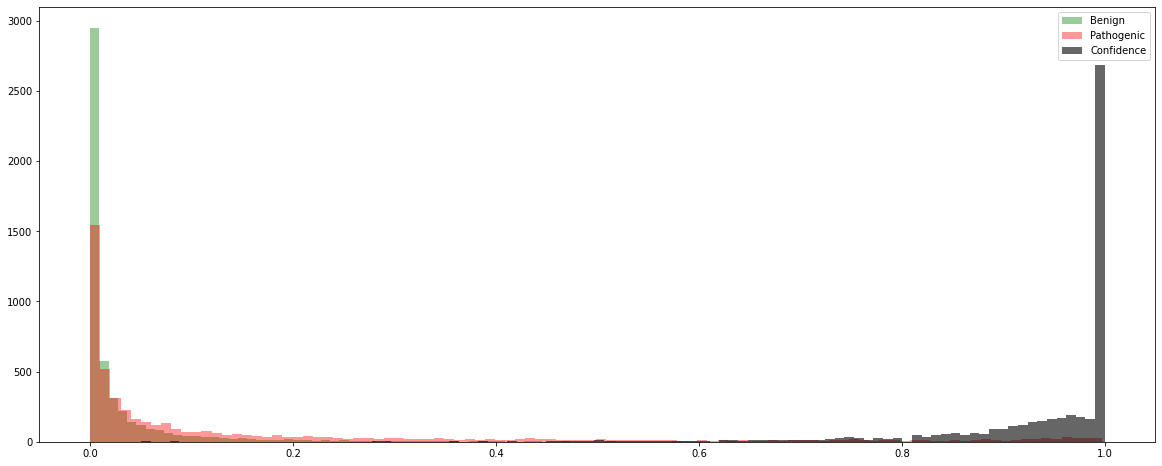

In [5]:
benign = 'benign_quantile'
pathogenic = 'pathogenic_quantile'

fig, axe = plt.subplots(1,1,figsize=(20,8))

axe.hist(thresholds[benign], bins=100, alpha=0.4, color='green', label='Benign')
axe.hist(thresholds[pathogenic], bins=100, alpha=0.4, color='red', label='Pathogenic')
axe.hist(thresholds['final_confidence'] / 100, bins=100, alpha=0.6, color='black', label='Confidence')  #/100, for formatting
axe.legend()
plt.show()

In [9]:
thresholds.sort_values(by='final_confidence')

pathogenic_quantile  n_pathogenic_total  n_pathogenic_correct  \
2600             0.000093                  30                    30   
2599             0.000093                  30                    30   
4416             0.000367                   1                     1   
4616             0.000121                   1                     1   
1145             0.000036                   1                     1   
...                   ...                 ...                   ...   
2242             0.845357                   1                     1   
2243             0.034319                   1                     1   
2246             0.992789                   1                     1   
2228             0.741551                   1                     1   
2568             0.862547                   2                     2   

      benign_quantile  n_benign_total  n_benign_correct  final_confidence  \
2600         0.000086              19                 1                 5   
2599         0.000086              19                 1                 5   
4416         0.000333               2                 1                 5   
4616         0.000114               2                 1                 5   
1145         0.000035               3                 1                 5   
...               ...             ...               ...               ...   
2242         0.000532               2                 2               100   
2243         0.000402               2                 2               100   
2246         0.004234               2                 2               100   
2228         0.010888               1                 1               100   
2568         0.001617               5                 5               100   

       gene_name  
2600  AC074212.6  
2599  AC074212.5  
4416    KIAA1147  
4616       DMRT3  
1145       DUSP6  
...          ...  
2242        HID1  
2243        GGA3  
2246    KIAA0195  
2228  AC079210.1  
2568     ARHGEF1  

[5138 rows x 8 columns]

In [10]:
merge

NameError: name 'merge' is not defined